# VMT and Demographics - Felicia Freeman & Aaron Barrall
Our research project aims to examine the demography of both low and high VMT areas in
San Diego County. Who lives in these tracts? Is there a difference between the
residents of high VMT tracts closer to the central business district and those
who live at the edges of urbanized places? Who might benefit from building or limiting
new housing there?


We hypothesize that VMT is negatively associated with various demographic factors,
including minority percentage of the population, income, and percent households that are
renters.

###  Core Strategies we learned in URB PLN 229!

* API Calls for the US Census
* Joining
* Text Parsing and Splitting
* Spatial Joins
* K Means
* Mapping
* Regression (Linear + Logistic)

In [20]:
#Load all all of the packages we need.

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import cenpy
from cenpy import products
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [21]:
#Load in the SANDAG Database.
sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/San_Diego_Region_SB743_VMT_Maps.shp') 

## Subsetting our data. 

We are concerned about data on the Census Tract level, for the estimated year 2025, using the most recently developed SANDAG model. We also subset for residents and VMT per capita to best match SB 743. 

In [22]:
gdf = sandagvmt[(sandagvmt['geo']=='Census Tract') & (sandagvmt['vmt_year']==2025) & (sandagvmt['version']=='ABM2+ / 2021 RP')&(sandagvmt['vmt_type']=='Residents') & (sandagvmt['vmt_metric']=='Per Capita')]

## Collect Census Data
We are using the Census API because of issues with cenpy. We are reading in variables concerning population, race, household income, and renter status. We created new columns for percentages of these relevant demographic variables. 

In [23]:
import requests
r = requests.get('https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E,B01001H_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E,B25119_001E,B25003_001E,B25003_003E&for=tract&in=state:06+county:073')
censusdata = r.json()
df=pd.DataFrame(censusdata[1:], columns=censusdata[0])
ca=df[df['state']=='06']
sd=ca[ca['county']=='073']
sd.head()

,NAME,B01001_001E,B01001H_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E,B25119_001E,B25003_001E,B25003_003E,state,county,tract
0,"Census Tract 165.04, San Diego County, California",6856,3138,6856,601,121,442,0,58,352,2144,46440,2511,1956,06,073,016504
1,"Census Tract 170.51, San Diego County, California",5188,2914,5188,346,0,737,168,0,448,575,106161,1988,765,06,073,017051
2,"Census Tract 170.53, San Diego County, California",3305,2552,3305,3,0,198,0,0,256,296,155208,1061,70,06,073,017053
3,"Census Tract 170.54, San Diego County, California",5731,4209,5731,82,9,370,0,0,252,809,101875,1874,455,06,073,017054
4,"Census Tract 170.52, San Diego County, California",5277,2629,5277,0,21,1530,23,150,267,657,103336,2221,1184,06,073,017052


In [24]:
sd.rename(columns={"B01001_001E":"total_pop","B01001H_001E":"white_nh","B25119_001E": "median_income", "B03002_001E": "total_race","B03002_004E":"black_nh", "B03002_005E":"native_na_alaska_nh","B03002_006E":"asian_nh","B03002_007E":"native_hi_pi_nh","B03002_008E":"other_race","B03002_009E":"mixed_race","B03002_012E": "total_hisp","B25003_001E":"total_housing", "B25003_003E":"total_renters"}, inplace=True)

sd['pc_nonHispanicWhite'] = sd.white_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_Black'] = sd.black_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_amindian'] = sd.native_na_alaska_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_pacislander'] = sd.native_hi_pi_nh.astype(float) / sd.total_pop.astype(float) * 100
sd['pc_asian'] = sd.asian_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_mixedrace'] = sd.mixed_race.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_hispanic'] = sd.total_hisp.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_other_race'] = sd.other_race.astype(float) / sd.total_pop.astype(float) * 100 

sd['pc_renter'] = sd.total_renters.astype(float) / sd.total_housing.astype(float) * 100


### Prepping for Join

Because we can't use cenpy, and because the SANDAG database does not have a GEOID Field, we need to load the tracts in with geometry.

In [25]:
censustractsGDF = sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/tl_2019_06_tract.shp') #Load in the Tracts with geometry so we can Database.
censustractsGDF = censustractsGDF[(censustractsGDF['COUNTYFP']=='073')]
sd['namesplit'] = sd['NAME'].str.split(',',expand=True,n=1)[0] #Split the name so we can join!

#### The Join

In [26]:
censustractsGDF = censustractsGDF.merge(sd,left_on='NAMELSAD',right_on='namesplit') #Join the Census Data to the Tract Ge information.
censustractsGDF = censustractsGDF.to_crs('EPSG:2230')
#set the tract geometry to the centroids
censustractsGDF.geometry =censustractsGDF.representative_point() 

#create the spatial join #Spatial Join the SANDAG and Census Data!
joinDf=gpd.sjoin(gdf,censustractsGDF,how='left',predicate='intersects') 

In [27]:
joinDf['median_income'] =joinDf['median_income'].astype('float64')
joinDf = joinDf[joinDf['median_income']>0]

In [28]:
joinDf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 618 entries, 3341 to 3967
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   OBJECTID             618 non-null    int64   
 1   version              618 non-null    object  
 2   vmt_year             618 non-null    float64 
 3   year_txt             618 non-null    object  
 4   scenario_i           618 non-null    float64 
 5   geo                  618 non-null    object  
 6   geo_id               618 non-null    float64 
 7   name                 618 non-null    object  
 8   vmt_type             618 non-null    object  
 9   vmt_metric           618 non-null    object  
 10  persons              618 non-null    float64 
 11  vmt                  618 non-null    float64 
 12  vmt_per_ca           618 non-null    float64 
 13  pctmean              618 non-null    float64 
 14  pctmeantxt           618 non-null    object  
 15  map_legend 

## Markdown Cell to explain purpose of the regulations and project. Aaron


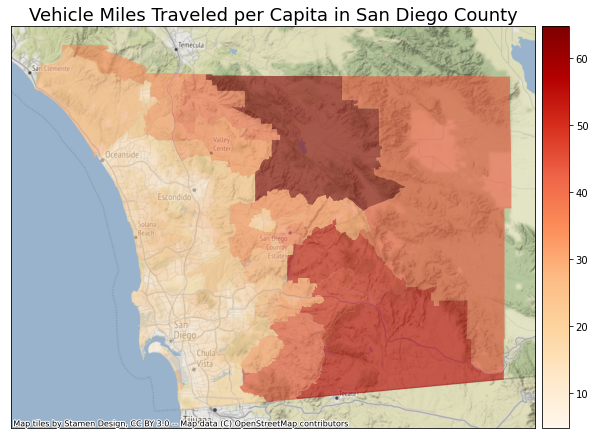

In [29]:
# VMT Map/ VMT Category Map
fig,ax = plt.subplots(figsize = (10,10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) # Reference: https://geopandas.org/en/stable/docs/user_guide/mapping.html
joinDf.plot('vmt_per_ca',  cmap='OrRd', legend=True,ax=ax,alpha=0.6,cax=cax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Vehicle Miles Traveled per Capita in San Diego County',fontsize=18)
ctx.add_basemap(ax,crs=2230)

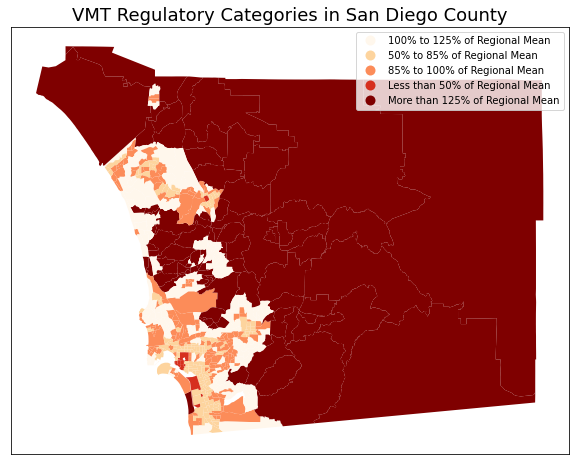

In [30]:
#VMT Category Map
vmt_reg_color = {'Less than 50% of Regional Mean':'green'}

fig0,ax0 = plt.subplots(figsize = (10,10))
joinDf.plot('map_legend',cmap='OrRd',categorical=True, legend=True,ax=ax0)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('VMT Regulatory Categories in San Diego County',fontsize=18)
ctx.add_basemap(ax,crs=2230)
handles,labels=ax0.get_legend_handles_labels()


#plt.legend(handler_map={})
#ax0.legend(handles, labels)

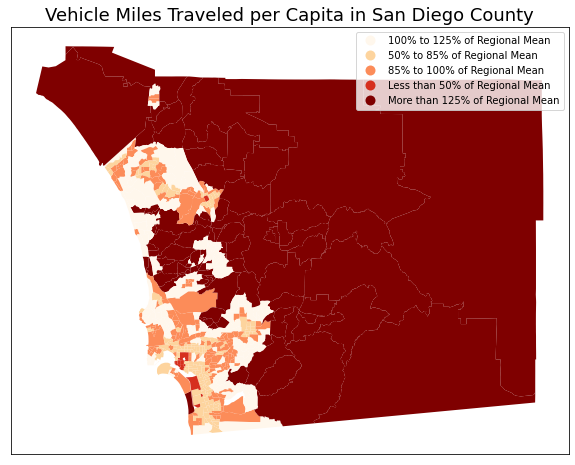

In [31]:
#VMT Category Map
fig0,ax0 = plt.subplots(figsize = (10,10))
joinDf.plot('map_legend',cmap='OrRd', legend=True,ax=ax0)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Vehicle Miles Traveled per Capita in San Diego County',fontsize=18)
ctx.add_basemap(ax,crs=2230)

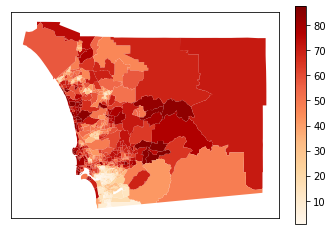

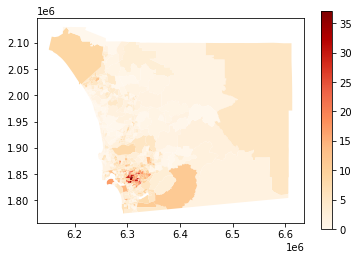

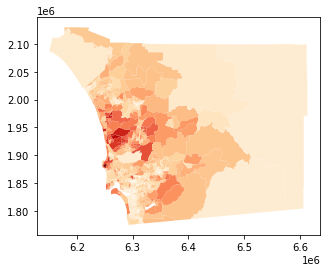

In [32]:
# Demographics Maps

ax0 = joinDf.plot('pc_nonHispanicWhite',cmap='OrRd',legend=True)
ax0.set_xticks([])
ax0.set_yticks([])


ax1 = joinDf.plot('pc_Black',  cmap='OrRd', legend=True)
ax2 =joinDf.plot('median_income',  cmap='OrRd', legend=False)



# Demographic and other maps.

### Markdown - Discuss Maps
We can point out several trends from these maps alone. Generally,

## Scatter Plots and box plots for demographics and VMT!

### Boxplots

Text(0.5, 1.0, 'Renter Status by Percentage VMT')

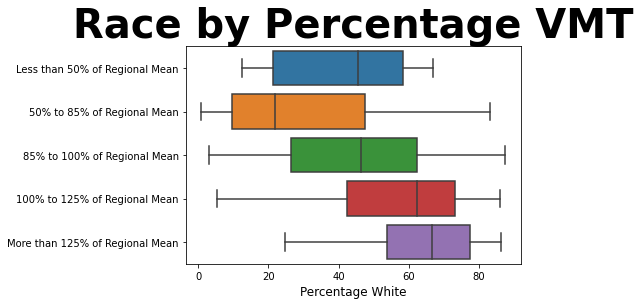

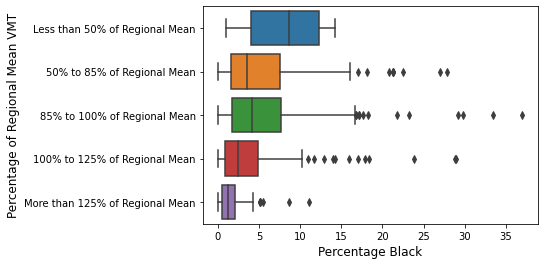

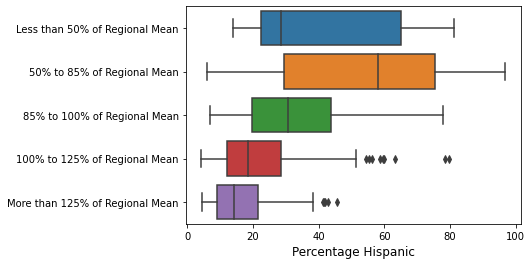

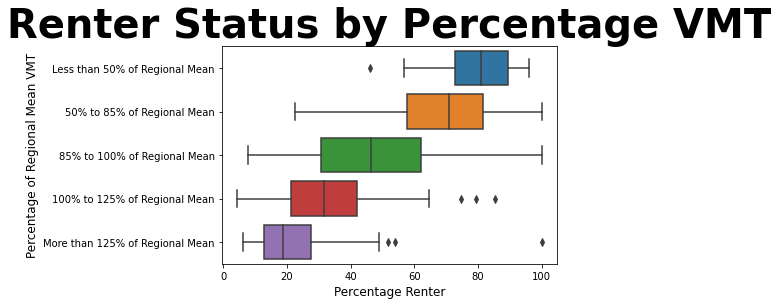

In [43]:
fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_nonHispanicWhite',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage White', size='large')
plt.ylabel('', size='large')
plt.title("Race by Percentage VMT", weight='bold', fontsize=40)

fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_Black',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage Black', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')

fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_hispanic',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage Hispanic', size='large')
plt.ylabel('', size='large')

fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_renter',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage Renter', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')
plt.title("Renter Status by Percentage VMT", weight='bold', fontsize=40)

### Discussion
These box plots display clear relationships between race, renter status, and VMT. In areas with higher VMT, less residents are renters, hispanic, and Black. Conversely, these areas are more white.

### Scatterplots and Regression Models

Text(0.5, 1.0, 'For Census Tracts in San Diego County')

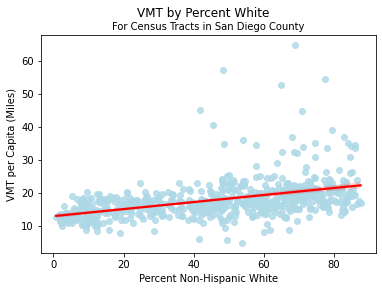

In [85]:
import seaborn as sns
ax = sns.regplot(x="pc_nonHispanicWhite", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'}) #Not a huge relation #Aaron to clean up.
plt.xlabel('Percent Non-Hispanic White')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent White')
plt.title('For Census Tracts in San Diego County',fontsize=10)


Text(0.5, 1.0, 'For Census Tracts in San Diego County')

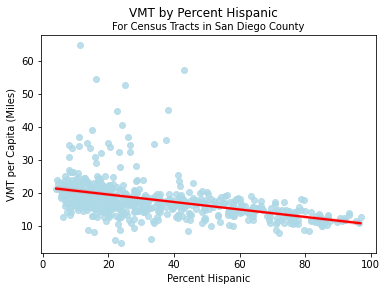

In [36]:
ax = sns.regplot(x="pc_hispanic", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'}) #Not a huge relation
plt.xlabel('Percent Hispanic')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent Hispanic')
plt.title('For Census Tracts in San Diego County',fontsize=10)


Text(0.5, 1.0, 'For Census Tracts in San Diego County')

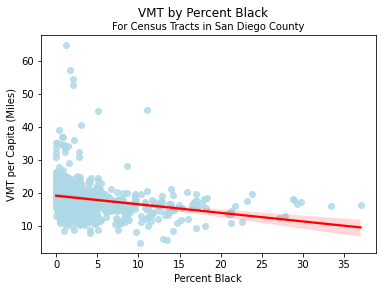

In [45]:
ax = sns.regplot(x="pc_Black", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'})
plt.xlabel('Percent Black')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent Black')
plt.title('For Census Tracts in San Diego County',fontsize=10)

Text(0.5, 1.0, 'For Census Tracts in San Diego County')

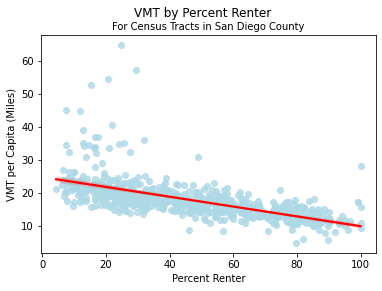

In [38]:
ax = sns.regplot(x="pc_renter", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'})
plt.xlabel('Percent Renter')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent Renter')
plt.title('For Census Tracts in San Diego County',fontsize=10)

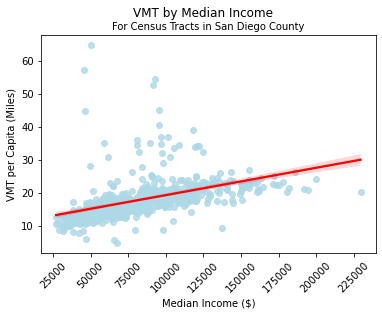

In [39]:
ax = sns.regplot(x="median_income", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'})
plt.xlabel('Median Income ($)')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Median Income')
plt.title('For Census Tracts in San Diego County',fontsize=10)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)


### Discussion
These scatterplots support similar conclusions, as well as introduce income as a variable. Areas with higher VMT per capita are richer and whiter, with fewer renters.

#### Logistic Regression - Machine Learning Model

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#adding more predictor variables
xvars = ['vmt','vmt_per_ca','median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']
yvar = 'map_legend' #The VMT Percent Category

df_to_fit = joinDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

In [88]:
LR =LogisticRegression(multi_class='multinomial', solver = "lbfgs", max_iter = 10000)

#fitting the model
LR.fit(X_train, y_train)

#this is a preliminary test on the accuracy of the model, based only on the training set. 
cross_val_score(LR, X_train, y_train, cv=5).mean()

0.6607059373539037

In [89]:
#this confusion matrix plots the actual vs predicted values of our model.
y_test_predictions = LR.predict(X_test)
from sklearn.metrics import confusion_matrix
LR_confusion = confusion_matrix(y_test, y_test_predictions)
LR_confusion

array([[27,  2, 11,  0,  5],
       [ 0, 30,  4,  0,  0],
       [15, 12, 18,  0,  0],
       [ 1,  3,  0,  0,  0],
       [ 7,  0,  4,  0, 16]])

In [90]:
LR.score(X_test,y_test)

0.5870967741935483

#### Discussion
Overall, the model predicts the correct map category about 60% of the time using our chosen demographic variables. 

#### Linear Regression

In [92]:
yvar = joinDf['vmt_per_ca']
xvars = joinDf[['median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']]
x=sm.add_constant(xvars)

linearModel = sm.OLS(yvar,xvars).fit()
print(linearModel.summary())

                                 OLS Regression Results                                
Dep. Variable:             vmt_per_ca   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              1495.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):                        0.00
Time:                        19:13:14   Log-Likelihood:                         -1895.0
No. Observations:                 618   AIC:                                      3800.
Df Residuals:                     613   BIC:                                      3822.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [93]:
#LINEAR REGRESSION - machine learning model
from sklearn.linear_model import LinearRegression
xvars = ['median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']
yvar = 'vmt_per_ca'

df_to_fit = joinDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

LinR = LinearRegression()
  
LinR.fit(X_train, y_train)

y_test_predictions = LinR.predict(X_test)

0.2720406063802381


3.1022649813251157


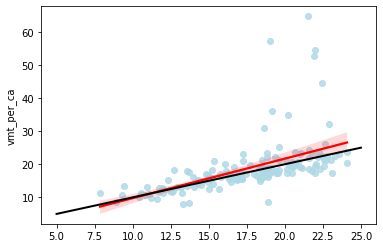

In [101]:
#plotting linear regression model
print(abs(y_test_predictions-y_test).mean())
fig, ax=plt.subplots()
sns.regplot(x=y_test_predictions, y=y_test, scatter_kws={'color':'lightblue'},line_kws={'color':'red'},ax=ax)
plt.plot([5, 25], [5, 25], color = 'black', linewidth = 2)

#### Discussion
Graphing the predicted values against the actual values of VMT per capita demonstrates the success of this model. The regression line is red, while the black line would be if the model performed perfectly. We can tell that the model is quite accurate in this visualization. 

## K - Means Cluster Analysis
We decided to perform a cluster analysis to identify any important groupings or hotspots related to VMT and the variables that contribute to it.

In [95]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

joinDf.dropna(inplace=True)

cols_to_plot = ['vmt','vmt_per_ca','total_pop','median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']

scaler = preprocessing.StandardScaler().fit(joinDf[cols_to_plot])
df_scaled = pd.DataFrame(scaler.transform(joinDf[cols_to_plot]), 
                         columns=cols_to_plot, index=joinDf.index)
df_scaled.dropna(inplace=True)


kmeans = KMeans(n_clusters=8, random_state=1).fit(df_scaled)


joinDf['cluster_id'] = kmeans.labels_

In [54]:
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [55]:
#code from lecture 15
def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

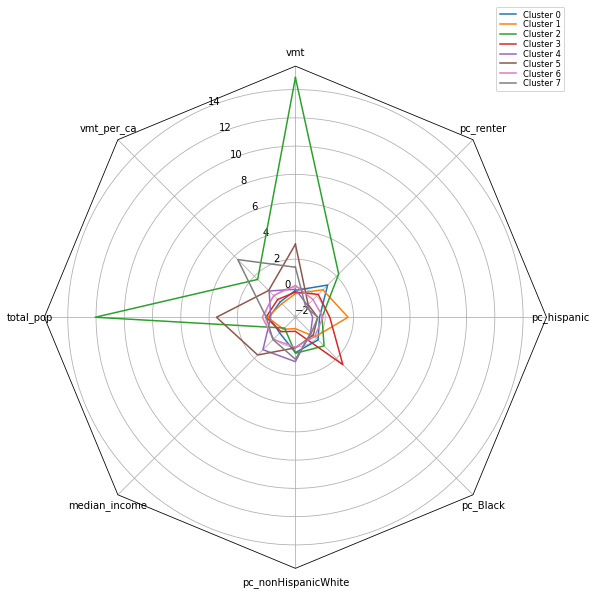

In [56]:
radar_plot(kmeans, df_scaled)

[]

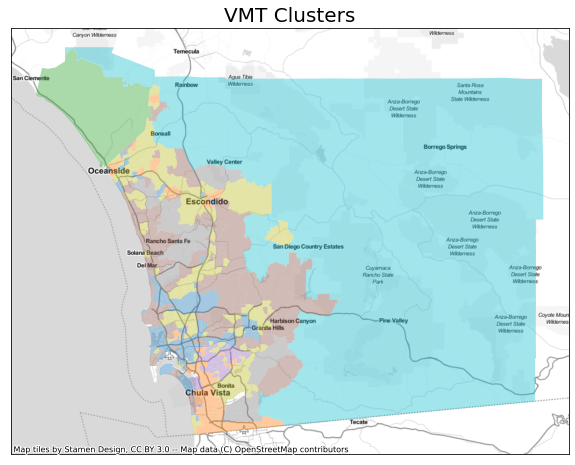

In [57]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))
joinDf.to_crs('EPSG:3857').plot('cluster_id', categorical=True, 
                                   ax=ax, alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title('VMT Clusters', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])


In [65]:
joinDf.groupby('cluster_id')['vmt_per_ca'].mean()

cluster_id
0    14.414474
1    13.350800
2    27.950000
3    15.888542
4    20.993125
5    21.316667
6    18.294564
7    39.935909
Name: vmt_per_ca, dtype: float64

<AxesSubplot:>

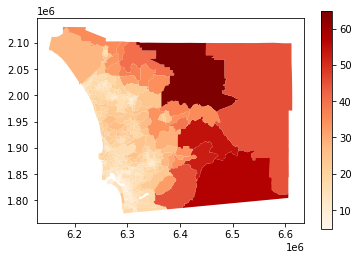

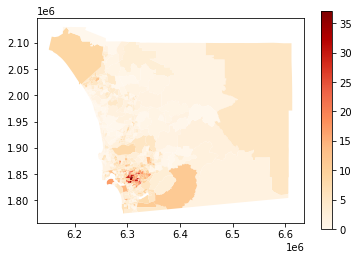

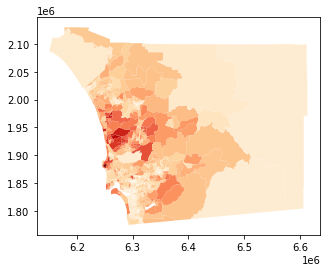

In [59]:
joinDf.plot('vmt_per_ca',  cmap='OrRd', legend=True)

joinDf.plot('pc_Black',  cmap='OrRd', legend=True)
joinDf.plot('median_income',  cmap='OrRd', legend=False)
#pc_hispanic

<AxesSubplot:>

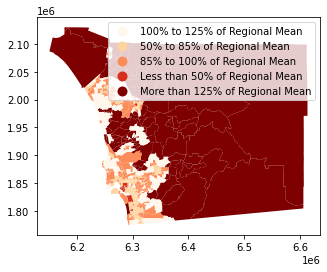

In [82]:
joinDf.plot('map_legend',cmap='OrRd', legend=True)

## Conclusion
...